In [1]:
import sys
import os
import joblib
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath('..'))
from src.preprocess import URLEmbeddingTransformer

c:\Users\andro\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.keras.backend.clear_session()

In [3]:
print(f"TensorFlow Version: {tf.__version__}")
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"GPU Terdeteksi: {physical_devices}")
    print("Detail:", tf.config.experimental.get_device_details(physical_devices[0]))
else:
    print("Failed")

TensorFlow Version: 2.10.0
GPU Terdeteksi: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Detail: {'device_name': 'NVIDIA GeForce RTX 4070 Laptop GPU', 'compute_capability': (8, 9)}


In [4]:
df = pd.read_csv('../data/data.csv')

In [5]:
df = df.drop_duplicates(subset=['URL'])
df = df.dropna(subset=['URL', 'ClassLabel'])

In [6]:
df.head()

,URL,url_length,has_ip_address,dot_count,https_flag,url_entropy,token_count,subdomain_count,query_param_count,tld_length,path_length,has_hyphen_in_domain,number_of_digits,tld_popularity,suspicious_file_extension,domain_name_length,percentage_numeric_chars,ClassLabel
0,https://www.womensweekly.com.sg,31,0,3,1,3.461320,6.0,2,1,2,0.00000,0,0,0,0,3,0.000000,1.0
1,http://116.53.34.145:34075/i,28,1,3,0,3.645593,7.0,2,1,9,2.00000,0,15,0,0,2,53.571429,0.0
2,http://58.23.215.31:8765/wzoptup.exe,36,1,4,0,4.086049,8.0,2,1,7,11.44075,0,13,0,1,3,36.111111,0.0
3,https://www.dudpro.co.il,24,0,3,1,3.772055,6.0,2,1,2,0.00000,0,0,0,0,2,0.000000,1.0
4,http://117.201.113.115:53518/i,30,1,3,0,3.819549,11.2,2,1,9,2.00000,0,17,0,0,3,0.371737,0.0


In [7]:
x = df['URL']
y = df['ClassLabel']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
x_train_list = x_train.tolist()
x_test_list = x_test.tolist()

In [10]:
class KerasDLClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=20, batch_size=32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def build_model(self):
    
        model = Sequential([
            Dense(128, activation='relu', input_shape=(384,)),
            Dropout(0.3), 
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid') 
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, x, y):

        x = np.array(x)
        y = np.array(y).astype('float32')
        
        self.model = self.build_model()
        early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
        
        print(" Training Neural Network dimulai...")
        self.model.fit(x, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1, callbacks=[early_stop])
        return self

    def predict(self, x):
        X = np.array(x)
        return (self.model.predict(x) > 0.5).astype("int32")
    
    def predict_proba(self, X):
        X = np.array(X)
        return self.model.predict(X)

In [11]:
dl_pipeline = Pipeline([
    ('processor', URLEmbeddingTransformer(model_name='all-MiniLM-L6-v2')),
    ('classifier', KerasDLClassifier(epochs=15, batch_size=32))
])

In [12]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [13]:
with tf.device('/GPU:0'):
    dl_pipeline.fit(x_train_list, y_train_enc)

📥 Loading Model: all-MiniLM-L6-v2...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 584.35it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


⚙️ Encoding URL...
 Training Neural Network dimulai...
Epoch 1/15
2019/2019 [==============================] - 12s 5ms/step - loss: 0.1588 - accuracy: 0.9614
Epoch 2/15
2019/2019 [==============================] - 8s 4ms/step - loss: 0.1417 - accuracy: 0.9666
Epoch 3/15
2019/2019 [==============================] - 10s 5ms/step - loss: 0.1382 - accuracy: 0.9676
Epoch 4/15
2019/2019 [==============================] - 9s 5ms/step - loss: 0.1354 - accuracy: 0.9679
Epoch 5/15
2019/2019 [==============================] - 11s 6ms/step - loss: 0.1321 - accuracy: 0.9685
Epoch 6/15
2019/2019 [==============================] - 10s 5ms/step - loss: 0.1297 - accuracy: 0.9685
Epoch 7/15
2019/2019 [==============================] - 11s 5ms/step - loss: 0.1260 - accuracy: 0.9689
Epoch 8/15
2019/2019 [==============================] - 13s 6ms/step - loss: 0.1225 - accuracy: 0.9689
Epoch 9/15
2019/2019 [==============================] - 10s 5ms/step - loss: 0.1186 - accuracy: 0.9692
Epoch 10/15
2019/201

In [14]:
y_pred = dl_pipeline.predict(x_test_list)

⚙️ Encoding URL...
505/505 [==============================] - 1s 2ms/step


c:\Users\andro\anaconda3\envs\deeplearning\lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


🎯 AKURASI FINAL: 0.9665 (96.65%)

📊 LAPORAN RAPOR MODEL:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10088
           1       0.96      0.95      0.96      6063

    accuracy                           0.97     16151
   macro avg       0.97      0.96      0.96     16151
weighted avg       0.97      0.97      0.97     16151



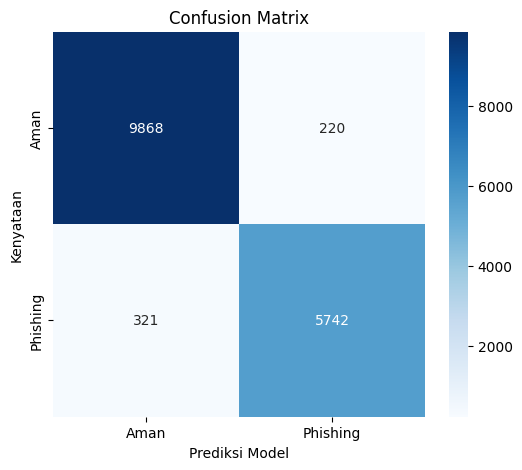

In [15]:

acc = accuracy_score(y_test_enc, y_pred)
print(f"🎯 AKURASI FINAL: {acc:.4f} ({acc*100:.2f}%)")


print("\n📊 LAPORAN RAPOR MODEL:")
print("="*60)
print(classification_report(y_test_enc, y_pred))
print("="*60)


cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Aman', 'Phishing'], yticklabels=['Aman', 'Phishing'])
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan')
plt.title('Confusion Matrix')
plt.show()

In [16]:
y_prob = dl_pipeline.predict_proba(x_test_list)

⚙️ Encoding URL...
505/505 [==============================] - 1s 2ms/step


c:\Users\andro\anaconda3\envs\deeplearning\lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [17]:
auc_score = roc_auc_score(y_test_enc, y_prob)

In [18]:
print(auc_score)

0.9753397710243868


In [19]:

save_dir = '../models'
os.makedirs(save_dir, exist_ok=True)

filename = 'phishing_detection_deeplearning_gpu.pkl'
save_path = os.path.join(save_dir, filename)

joblib.dump(dl_pipeline, save_path)

INFO:tensorflow:Assets written to: ram://e252bad8-17a4-4e98-9b82-fd366caa57aa/assets


['../models\\phishing_detection_deeplearning_gpu.pkl']